In [1]:
# Packages and Settings 
%matplotlib notebook
import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd

## Import Data 

Generate the training data for eddy-viscosity relation in the ML-RANS framework. The two inputs features are:

$$q_1 = 50k/(50k+u_iu_i)$$

$$q_2 = k/(k+50\nu\omega)$$

The output data is:
$$5\nu_t/(5\nu_t+3k/\omega)$$

the training data is generated by equally sample 50 points in channel flow at:

$$Re_\tau=\left\{180, 395, 640, 1020\right\}$$

In [2]:
TF_inputs_data = np.genfromtxt("inputs.txt")
TF_outputs_data = np.reshape(np.genfromtxt("outputs.txt"),[-1,1])
TF_weight_data = np.ones(len(TF_outputs_data))
TF_weight_data[0] = 1.0

<IPython.core.display.Javascript object>


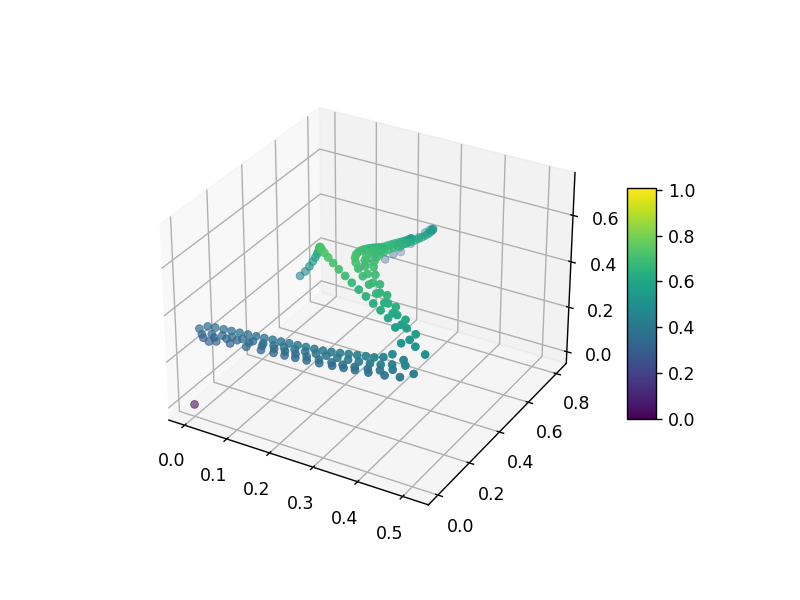

In [3]:
# visualize training data
from matplotlib import cm
from matplotlib.ticker import LinearLocator
# from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

points = ax.scatter(TF_inputs_data[:,0], TF_inputs_data[:,1], 
                    np.squeeze(TF_outputs_data),
                    c=np.squeeze(TF_outputs_data), 
                    cmap='viridis', vmin = 0, vmax = 1.01,
                    linewidth=0.5)
fig.colorbar(points,shrink=0.5, aspect=8)

## Training ML model

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
print(keras.__version__)

2.3.0-tf


In [5]:
np.random.seed(6)
tf.random.set_seed(6)

In [6]:
def build_3layer_model_l1l2(n_node = 32, l1reg = 1e-4, l2reg = 1e-4):
  model = keras.Sequential([
    layers.Dense(n_node, activation='tanh', input_shape=[2], 
                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1reg, l2=l2reg)),
    layers.Dense(n_node, activation='tanh',
                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1reg, l2=l2reg)),
    layers.Dense(n_node, activation='tanh',
                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1reg, l2=l2reg)),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.002)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 1000 == 0: print('')
    if epoch % 10 == 0: print('.', end='')
    

In [7]:
model = build_3layer_model_l1l2(n_node = 24, l1reg = 4e-6, l2reg = 6e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


In [8]:
EPOCHS = 5000
history = model.fit(TF_inputs_data, TF_outputs_data, 
                    sample_weight=TF_weight_data,
                    epochs=EPOCHS,
                    verbose=0, 
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

<IPython.core.display.Javascript object>


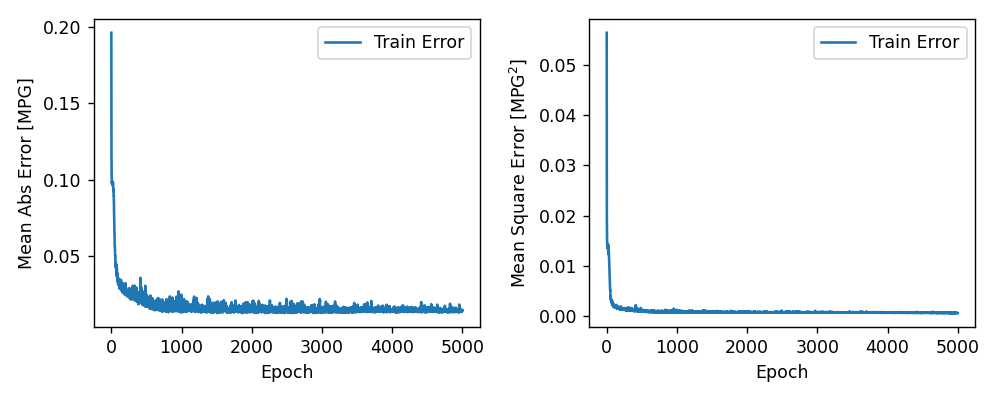

no validation data
no validation data


In [9]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

fig, axs = plt.subplots(1,2,figsize=(8,3.2))
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Mean Abs Error [MPG]')
axs[0].plot(hist['epoch'], hist['mae'],label='Train Error')
try:
    axs[0].plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
except:
    print("no validation data")
axs[0].legend()

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Mean Square Error [MPG$^2$]')
axs[1].plot(hist['epoch'], hist['mse'], label='Train Error')
try:
    axs[1].plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
except:
    print("no validation data")

axs[1].legend()
fig.tight_layout()

## Model Performance

#### 2D Contours

<IPython.core.display.Javascript object>


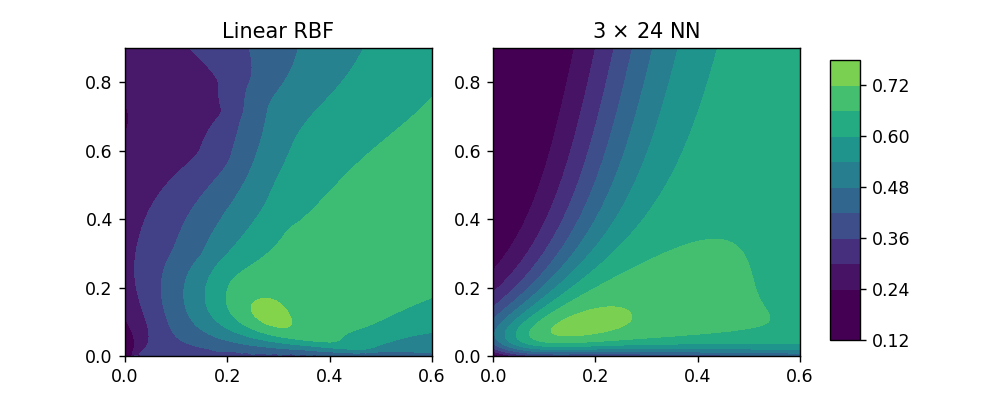

In [10]:
from scipy.interpolate import griddata
from scipy.interpolate import Rbf

grid_x, grid_y = np.mgrid[0:0.6:200j, 0:0.9:200j]
z_pred_flat = model.predict(np.transpose([grid_x.flatten(),grid_y.flatten()])).flatten()
z_pred_reg = z_pred_flat.reshape((200, 200))

F_rbf = Rbf(TF_inputs_data[0:200,0], TF_inputs_data[0:200,1], np.squeeze(TF_outputs_data[0:200]), 
            function='linear', 
            epsilon=8, smooth=1e-3)
z_interp = F_rbf(grid_x.flatten(),grid_y.flatten()).reshape((200, 200))


fig, axs = plt.subplots(1,2,figsize=(8,3.2))
axs[0].contourf(grid_x, grid_y, z_interp, levels=10, vmin = 0.24, vmax = 0.88)

cs = axs[1].contourf(grid_x, grid_y, z_pred_reg, levels=10, vmin = 0.24, vmax = 0.88)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.03, 0.7])
fig.colorbar(cs, cax=cbar_ax)
axs[0].title.set_text("Linear RBF")
axs[1].title.set_text(r"3 $\times$ 24 NN")

#### 3D Surface

<IPython.core.display.Javascript object>


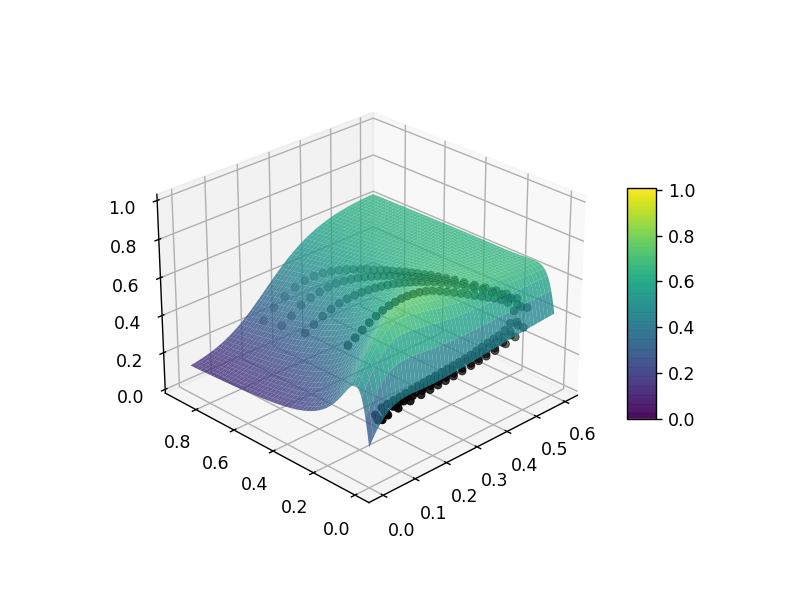

In [11]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


surf = ax.plot_surface(grid_x, grid_y, z_pred_reg,
                       cmap='viridis', edgecolor='none',
                       vmin = 0, vmax = 1.01, alpha=0.8)

points = ax.scatter(TF_inputs_data[1:,0], TF_inputs_data[1:,1], 
                    np.squeeze(TF_outputs_data[1:]),
                    c='k', 
                    cmap='viridis', vmin = 0, vmax = 1.01,
                    linewidth=0.5)


ax.set_zlim(0, 1.01)
ax.view_init(elev=26.9, azim=-134.4)

fig.colorbar(surf, shrink=0.5, aspect=8)

#### Projection on Feature surfaces

<IPython.core.display.Javascript object>


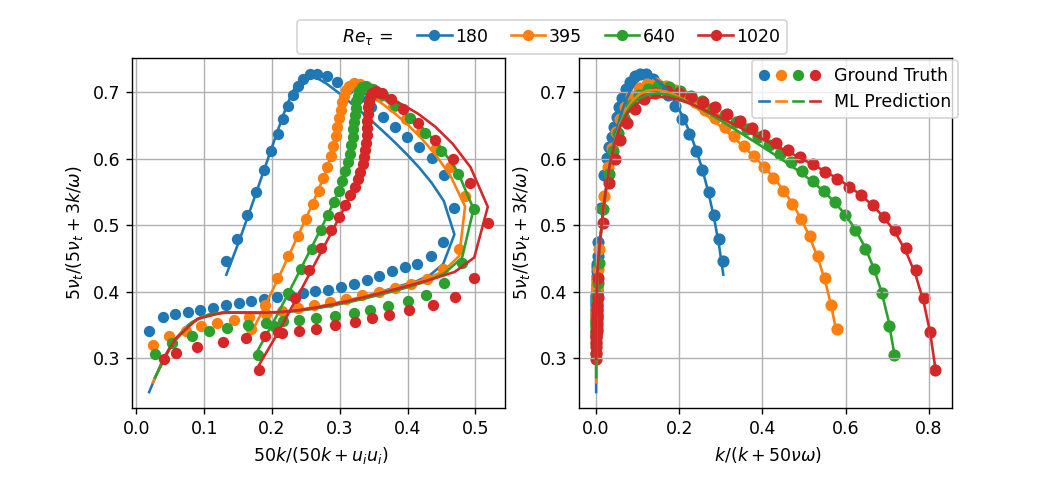

In [12]:
import matplotlib.legend_handler
nutnd_pred = model.predict(TF_inputs_data[:,:])
fig, axs = plt.subplots(1,2,figsize=(8.4,3.5))

l_T = []
l_Ideal = []
l_ML = []

l_T.append(ax.plot([], [], ' ')[0])

axs[0].grid()
for i in range(4):
    l_T.append(ax.plot([], [],linestyle = '-',color='C'+str(i), marker='o', markeredgecolor='C'+str(i),markerfacecolor='C'+str(i), markersize=5.5,markevery=37)[0])
    l_Ideal.append(axs[0].plot(TF_inputs_data[50*i+1:50*(i+1)+1,0], TF_outputs_data[50*i+1:50*(i+1)+1],
                  color='C'+str(i),linestyle = '',marker='o', markeredgecolor='C'+str(i),markerfacecolor='C'+str(i), markersize=5.5)[0])
# for i in range(4):
    l_ML.append(axs[0].plot(TF_inputs_data[50*i+1:50*(i+1)+1,0], nutnd_pred[50*i+1:50*(i+1)+1],color='C'+str(i))[0])
    
axs[0].set_ylabel(r"$5\nu_t/(5\nu_t+3k/\omega)$")
axs[0].set_xlabel(r" $50k/(50k+u_iu_i)$")
legend1=plt.legend(handles=l_T,
           labels=[r"${Re}_\tau$ = ",'180','395','640','1020'],
           ncol=6,
           borderaxespad=0.01,
           handletextpad=0.2,
           columnspacing=1.3,
           loc='center',bbox_to_anchor=(-0.1,1.06))

axs[1].grid()
for i in range(4):
    axs[1].scatter(TF_inputs_data[50*i+1:50*(i+1)+1,1], TF_outputs_data[50*i+1:50*(i+1)+1])
for i in range(4):
    axs[1].plot(TF_inputs_data[50*i+1:50*(i+1)+1,1], nutnd_pred[50*i+1:50*(i+1)+1])

axs[1].set_ylabel(r"$5\nu_t/(5\nu_t+3k/\omega)$")
axs[1].set_xlabel(r" $k/(k+50\nu\omega)$")

handles = [(l_Ideal[0],l_Ideal[1],l_Ideal[2],l_Ideal[3]), (l_ML[0],l_ML[1],l_ML[2],l_ML[3])]
labels = ['Ground Truth','ML Prediction']
legend2=plt.legend(handles=handles,labels=labels,ncol=1,loc='center',
                  bbox_to_anchor=(0.74,0.91),
                  handlelength = 3.5,
                  handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)})
plt.gca().add_artist(legend1)

plt.subplots_adjust(wspace=0.2, hspace=0.08, bottom=0.15)


## Save the Model

In [13]:
from tensorflow import keras
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name="Input"))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./ML_RANS_Model",
                  name="ML_RANS_Model.pb",
                  as_text=False)

--------------------------------------------------
Frozen model layers: 
Input
sequential/dense/MatMul/ReadVariableOp/resource
sequential/dense/MatMul/ReadVariableOp
sequential/dense/MatMul
sequential/dense/BiasAdd/ReadVariableOp/resource
sequential/dense/BiasAdd/ReadVariableOp
sequential/dense/BiasAdd
sequential/dense/Tanh
sequential/dense_1/MatMul/ReadVariableOp/resource
sequential/dense_1/MatMul/ReadVariableOp
sequential/dense_1/MatMul
sequential/dense_1/BiasAdd/ReadVariableOp/resource
sequential/dense_1/BiasAdd/ReadVariableOp
sequential/dense_1/BiasAdd
sequential/dense_1/Tanh
sequential/dense_2/MatMul/ReadVariableOp/resource
sequential/dense_2/MatMul/ReadVariableOp
sequential/dense_2/MatMul
sequential/dense_2/BiasAdd/ReadVariableOp/resource
sequential/dense_2/BiasAdd/ReadVariableOp
sequential/dense_2/BiasAdd
sequential/dense_2/Tanh
sequential/dense_3/MatMul/ReadVariableOp/resource
sequential/dense_3/MatMul/ReadVariableOp
sequential/dense_3/MatMul
sequential/dense_3/BiasAdd/ReadVari

'./ML_RANS_Model/ML_RANS_Model.pb'